In [1]:
import numpy as np
from numba import njit
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, Normalize
import pandas as pd
import pickle
from datetime import datetime
import strax
import straxen
import cutax
from tqdm.notebook import tqdm, trange
strax.utils.tqdm = tqdm
from multihist import Hist1d, Histdd

import copy
from matplotlib import cm
from scipy import stats
import feldman_cousins as fc
from scipy.stats import poisson
from scipy.optimize import minimize, rosen, rosen_der


In [20]:
hour=183.78
decay=0.9
gamma_ineff=0.9
s_hour=15393/0.9
b_hour=142.21*0.95

bkg_s=hour/b_hour
sim_s=hour/s_hour

In [ ]:
# data_cuts=pd.read_hdf("good_data.hdf5")
bkg=pd.read_hdf("/dali/lgrandi/ghusheng/YBe_data/YBe_superrun/Y88_event_info_143runs_142.21hrs_all_cuts_with_run_ids.hdf5")
data=pd.read_hdf("/dali/lgrandi/ghusheng/YBe_data/YBe_superrun/YBe_event_info_239runs_183.78hrs_all_cuts_with_run_ids.hdf5")
sim=pd.read_hdf("good_sim.hdf5")

In [ ]:
%run -i 'YBe_tool.py'
%run -i 'stuff_to_load.py'

In [ ]:
temp1 = data.query('cs1<=1e5 and cs1>=1e2 and cs2<=8e6 and cs2>=5e3')
temp2 = bkg.query('cs1<=1e5 and cs1>=1e2 and cs2<=8e6 and cs2>=5e3')
gamma=temp1.append(temp2)

del data
del bkg

In [2]:
st = cutax.xenonnt_online(
    output_folder='/dali/lgrandi/scli/strax_data',
)

In [3]:
runs_all = st.select_runs(
    # include_tags='sr0_preliminary', 
    exclude_tags=(
        'ramp_up',
        'messy',
        'bad',
        'abandon',
        'hot_spot'
    ),
    run_mode=[
        'y*_linked'
    ]
)

Checking data availability:   0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
# gamma['date']=[datetime.fromtimestamp(t/1e9) for t in gamma.time]

In [25]:
runs=gamma['run_id'].unique()
runs.sort(axis=0)

In [26]:
livetime=[]
time_s=[]
for r in runs:
    tmp = runs_all[runs_all.name==r]
    livetime.append(tmp.livetime.values[0])
    time_s.append(tmp.start.values[0])

In [ ]:
import tqdm
count=[]
for r in tqdm.tqdm(runs):
    tmp=gamma[gamma['run_id']==r]
    count.append(len(tmp))
    del tmp

In [ ]:
rate=np.divide(count,livetime/np.timedelta64(1, 's'))

In [ ]:
# rate_cor=[]
# for i in rate:
#     if i > 100:
#         i=np.nan
#     rate_cor.append(i)

In [ ]:
index=239
time_yb=time_s[:index]
rate_yb=rate[:index]
time_y8=time_s[index:]
rate_y8=rate[index:]

In [ ]:
r_YBe=np.sum(count[:index])/np.sum(livetime[:index]/np.timedelta64(1, 's'))
r_Y88=np.sum(count[index:])/np.sum(livetime[index:]/np.timedelta64(1, 's'))
print('averge_decay:',r_Y88/r_YBe)
r_YBe, r_Y88

In [ ]:
r_first=np.sum(count[:10])/np.sum(livetime[:10]/np.timedelta64(1, 's'))
r_YBe/r_first

In [ ]:
def get_dt_h(time):
    return (time-np.datetime64('2022-10-01T03:30'))/np.timedelta64(1, 'h')

one week:0.9599981812223577


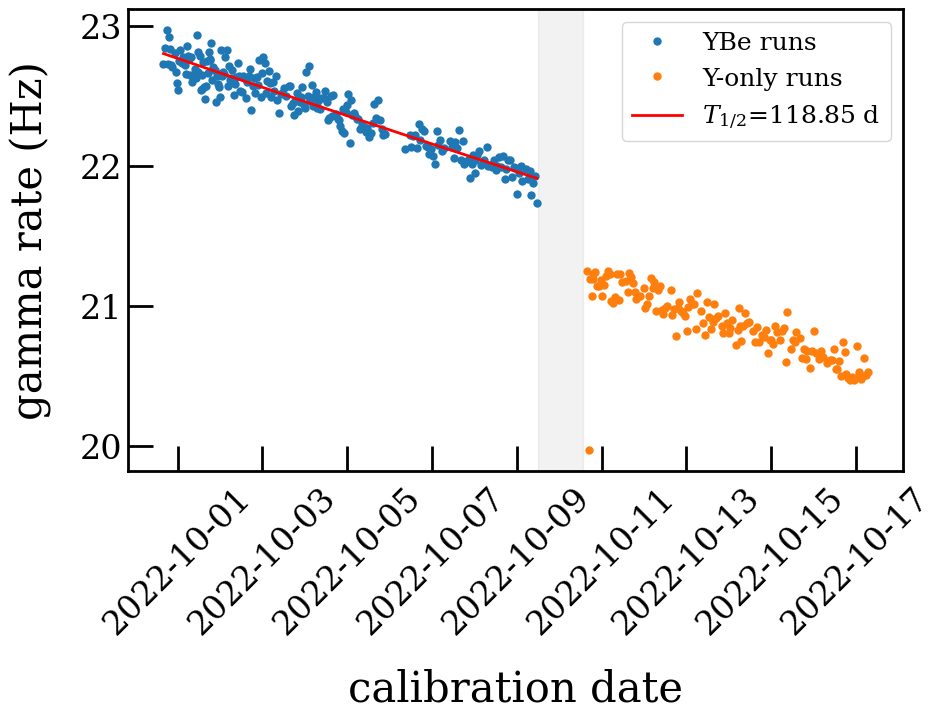

In [44]:
%matplotlib inline

from scipy.optimize import curve_fit
plt.figure(figsize=(10,6))
plt.plot(time_yb,rate_yb,'.',label='YBe runs')
plt.plot(time_y8,rate_y8,'.',label='Y-only runs')
plt.ylabel('gamma rate (Hz)')
plt.xlabel('calibration date')
plt.xticks(rotation = 45)

plt.axvspan(np.datetime64('2022-10-09T12:00'),np.datetime64('2022-10-10T13:30'), alpha=0.1, color='grey')


def fun(x, A, B) : 
    return A*np.exp(-x/B)+5 # assume 5Hz fixed bkg rate

ts = np.array([get_dt_h(t) for t in time_yb])
p, c = curve_fit(fun, ts, rate_yb,p0=[10,50])

plt.plot(time_yb, fun(ts, *p), color='r',
         label='$T_{1/2}$='+f'{p[1]/24*np.log(2):.2f} d') #label=f'y={p[0]:.2f}*exp(x/{p[2]:.2f})+{p[1]:.2f}')#label=f'time constant:{p[2]:.2f} d')
plt.legend(fontsize=18)

print(f"one week:{np.exp(-24*7/p[1])}")
plt.show()
